<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>

<h2>2.1 Data </h2>

<h3>2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3>2.1.2 Example Data Points</h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h2> 2.3 Train and Test Construction </h2>


<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis</h1>

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')



<h2> 3.1 Reading data and basic stats </h2>

In [57]:
df = pd.read_csv('train.csv')
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

<Axes: xlabel='is_duplicate'>

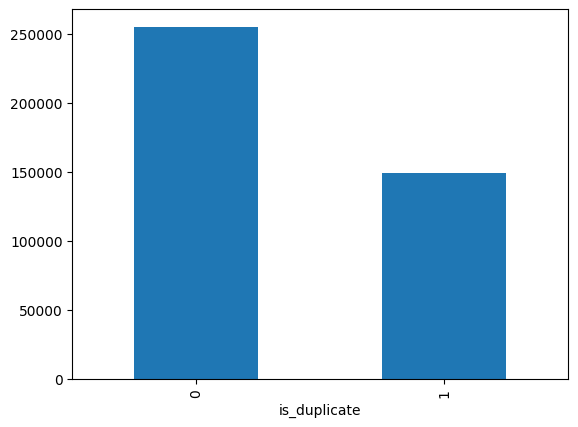

In [65]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [69]:
print("Total Number of Quetion pair for training: {}".format(len(df)))

Total Number of Quetion pair for training: 404290


In [71]:
print("Question pair not similar (is_duplicate = 0) :  {}%".format(100 - round(df['is_duplicate'].mean()*100,2)))
print("Question pair are similar (is_duplicate = 1) :  {}%".format(round(df['is_duplicate'].mean()*100,2)))

Question pair not similar (is_duplicate = 0) :  63.08%
Question pair are similar (is_duplicate = 1) :  36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [73]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 


Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



In [74]:
q_vals=qids.value_counts()

q_vals=q_vals.values

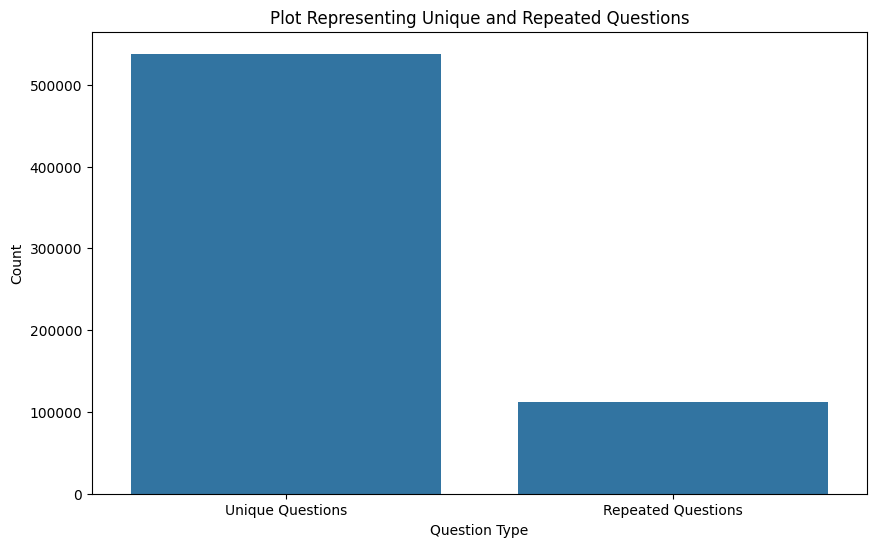

In [80]:
# Data for plot
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qs, qs_morethan_onetime]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Plot Representing Unique and Repeated Questions")
sns.barplot(x=x, y=y)
plt.xlabel("Question Type")
plt.ylabel("Count")
plt.show()

<h3> 3.2.3 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



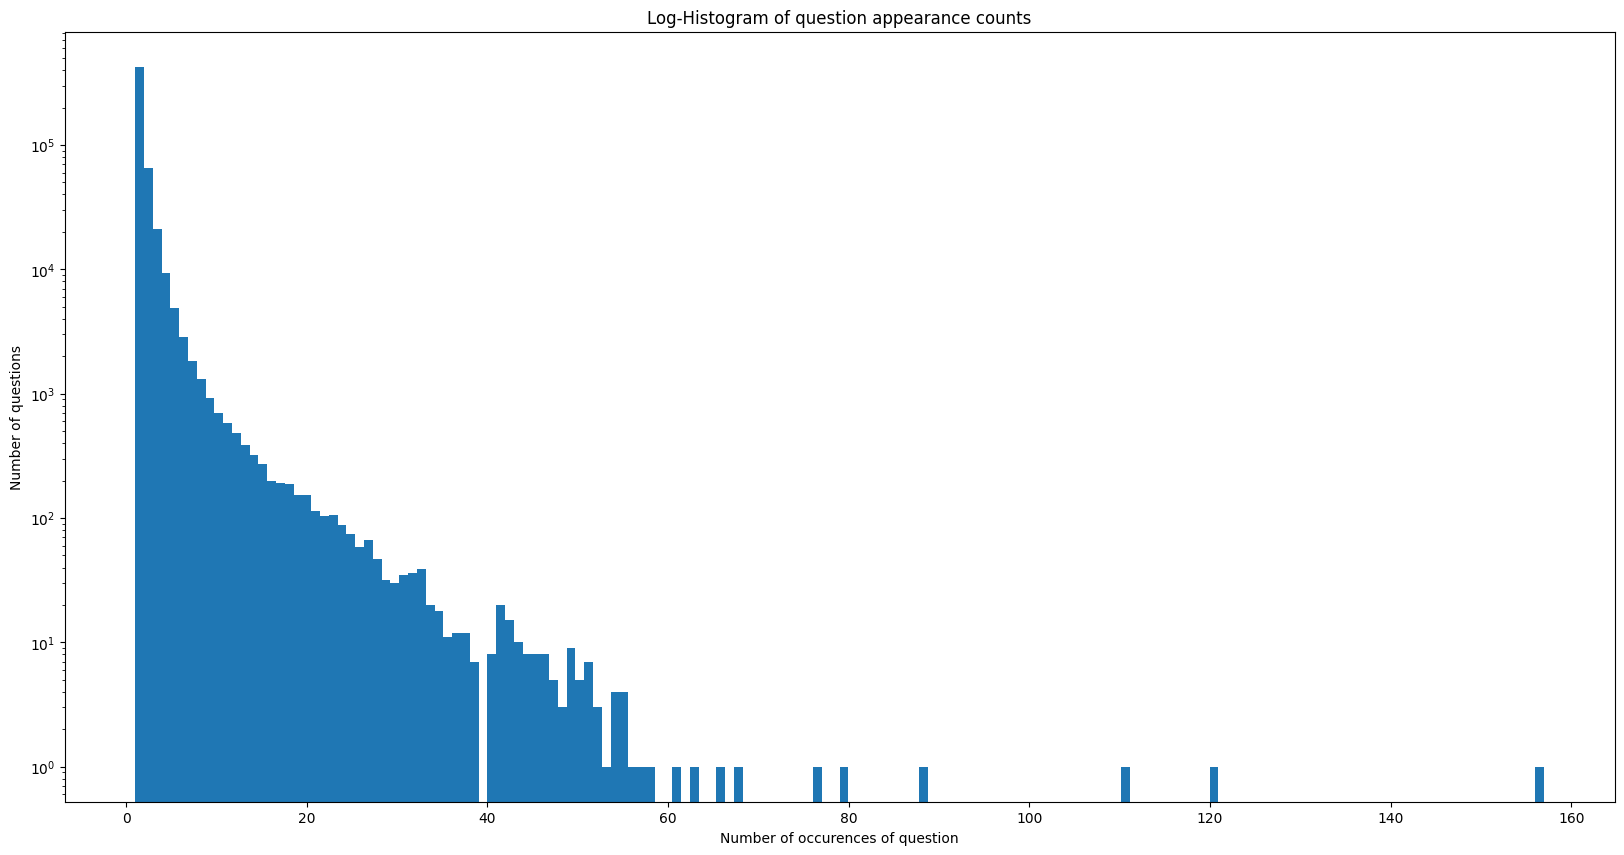

In [82]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h2> 3.3 Preprocessing </h2>

In [58]:
new_df = df.sample(60000,random_state=2)

In [59]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  What is the best marketing automation tool for...   
115086  I am poor but I want to invest. What should I do?   
327711  I am from India and live abroad. I met a guy f...   
367788  Why do so many people in the U.S. hate the sou...   
151235                Consequences of Bhopal gas tragedy?   

                                                question2  is_duplicate  
398782  What is the best marketing automation tool for...             1  
115086  I am quite poor and I want to be very rich. Wh...             0  
327711  T.I.E.T to Thapar University to Thapar Univers...             0  
367788  My boyfriend doesnt feel guilty when he hurts ...             0  
151235  What was the reason behind the Bhopal gas trag...             0

In [5]:
def preprocess(q):

    q = str(q).lower().strip()

    #replace certain special characters with their string equivalents
    q = q.replace('%', ' persent ')
    q = q.replace('$', ' doller ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)


    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    


In [6]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [7]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  
398782  what is the best marketing automation tool for...             1  
115086  i am quite poor and i want to be very rich  wh...             0  
327711  t i e t to thapar university to thapar univers...             0  
367788  my boyfriend doesnt feel guilty when he hurts ...             0  
151235  what was the reason behind the bhopal gas tragedy             0

<h2>3.4 Basic Feature Extraction </h2>



Let us now construct a few features like:

 - ____q1_len____ = Length of q1
 - ____q2_len____ = Length of q2
 - ____q1_nun_words____ = Number of words in Question 1
 - ____q2_num_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)


In [8]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [9]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
398782      75      76            13            13  
115086      48      56            13            16  
327711     104     119            28            21  
367788      58     145            14            32  
151235      34      49             5             9

In [10]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)


In [11]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  
398782      75      76            13            13           12  
115086      48      56            13            16            8  
327711     104     119            28            21            4  
367788      58     145            14            32            1  
151235      34      49             5             9            3

In [12]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [13]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()


id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  
398782      75      76            13            13           12          26  
115086      48      56            13            16            8          24  
327711     104     119            28            21            4          38  
367788      58     145            14            32            1          34  
151235      34      49             5             9            3          13

In [14]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
398782      75      76            13            13           12          26   
115086      48      56            13            16            8          24   
327711     104     119            28            21            4          38   
367788      58     145            14            32            1          34   
151235      34      49             5             9            3          13   

        word_share  
398782        0.46  
115086        0.33  
327711        0.11  
367788        0.03  
151235        0.23

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitwagh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h2> 3.5 Advanced Feature ExtVraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [16]:
# Advance Features

from nltk.corpus import stopwords

STOP_WORDS = stopwords.words("english")

def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001 

    token_features = [0.0]*8

    # Convert sentences into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both questions is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both questions is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [17]:
token_features = new_df.apply(fetch_token_features, axis=1)

In [18]:
new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))


In [19]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  word_total  \
398782      75      76            13            13  ...          26   
115086      48      56            13            16  ...          24   
327711     104     119            28            21  ...          38   
367788      58     145            14            32  ...          34   
151235      34      49             5             9  ...          13   

        word_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
398782        0.46  0.874989  0.874989  0.999980  0.999980  0.923070   
115086        0.33  0.666644  0.499988  0.714276  0.624992  0.583328   
327711        0.11  0.000000  0.000000  0.428565  0.272725  0.149999   
367788        0.03  0.000000  0.000000  0.000000  0.000000  0.000000   
151235        0.23  0.749981  0.599988  0.000000  0.000000  0.599988   

         ctc_max  last_word_eq  first_word_eq  
398782  0.923070           1.0            1.0  
115086  0.466664           1.0            1.0  
327711  0.115384           0.0            0.0  
367788  0.000000           0.0            0.0  
151235  0.333330           1.0            0.0  

[5 rows x 21 columns]

In [21]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [22]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [23]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min  \
398782      75      76            13            13  ...  0.874989  0.999980   
115086      48      56            13            16  ...  0.499988  0.714276   
327711     104     119            28            21  ...  0.000000  0.428565   
367788      58     145            14            32  ...  0.000000  0.000000   
151235      34      49             5             9  ...  0.599988  0.000000   

         csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
398782  0.999980  0.923070  0.923070           1.0            1.0   
115086  0.624992  0.583328  0.466664           1.0            1.0   
327711  0.272725  0.149999  0.115384           0.0            0.0   
367788  0.000000  0.000000  0.000000           0.0            0.0   
151235  0.000000  0.599988  0.333330           1.0            0.0   

        abs_len_diff  mean_len  longest_substr_ratio  
398782           0.0      13.0              0.855263  
115086           3.0      13.5              0.224490  
327711           6.0      23.0              0.047619  
367788          17.0      21.5              0.050847  
151235           4.0       7.0              0.542857  

[5 rows x 24 columns]

In [24]:
!pip install fuzzywuzzy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [25]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [26]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

In [27]:
# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [28]:
print(new_df.shape)
new_df.head()

(60000, 28)


id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
398782      75      76            13            13  ...  0.923070   
115086      48      56            13            16  ...  0.466664   
327711     104     119            28            21  ...  0.115384   
367788      58     145            14            32  ...  0.000000   
151235      34      49             5             9  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          26                  29   
367788              0.050847          29                  41   
151235              0.542857          55                  70   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                65               74  
327711                34               43  
367788                23               30  
151235                48               69  

[5 rows x 28 columns]

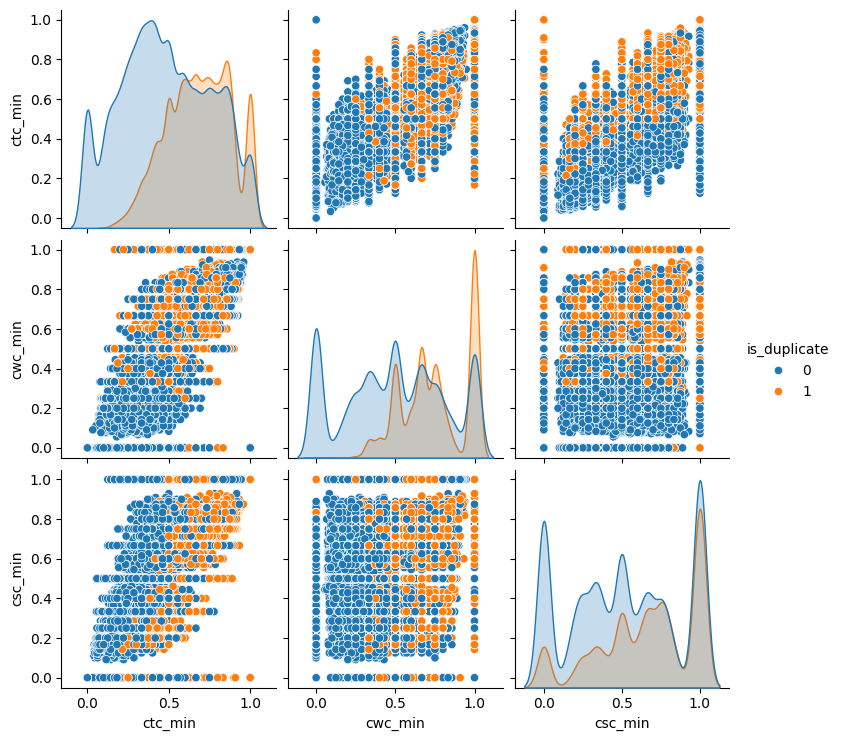

In [29]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

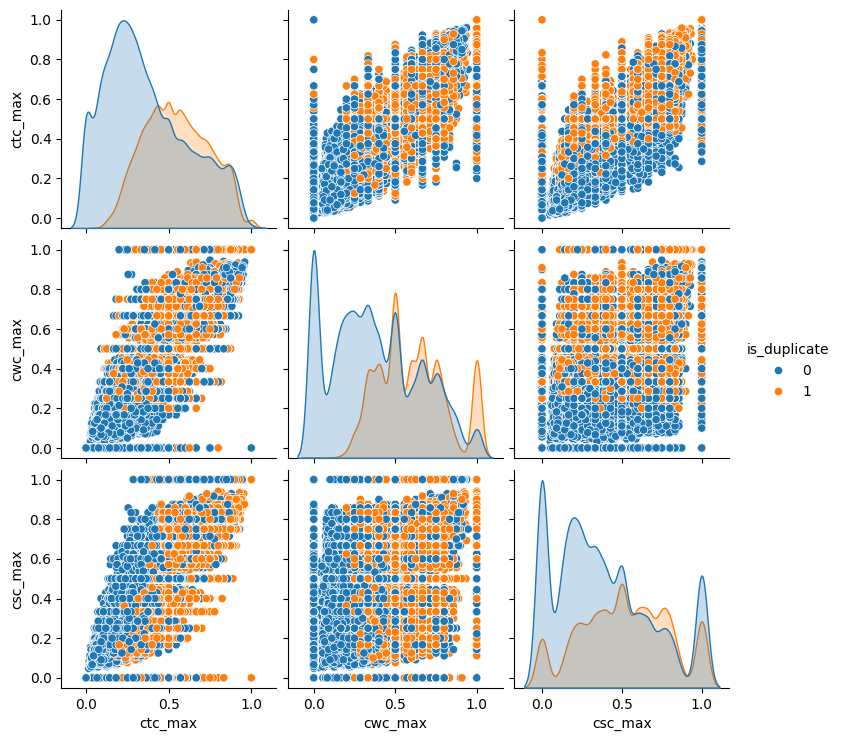

In [30]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

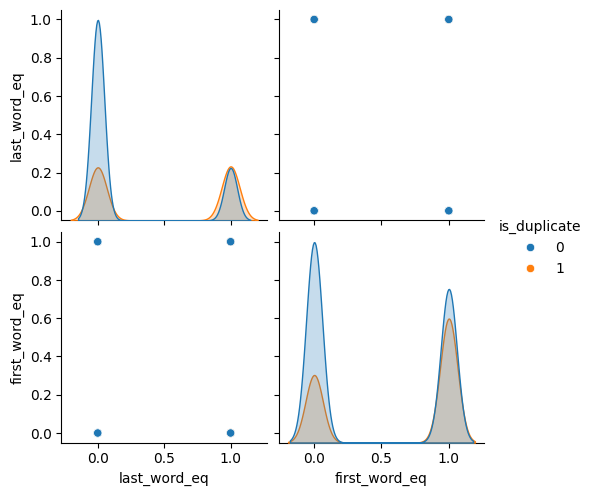

In [31]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

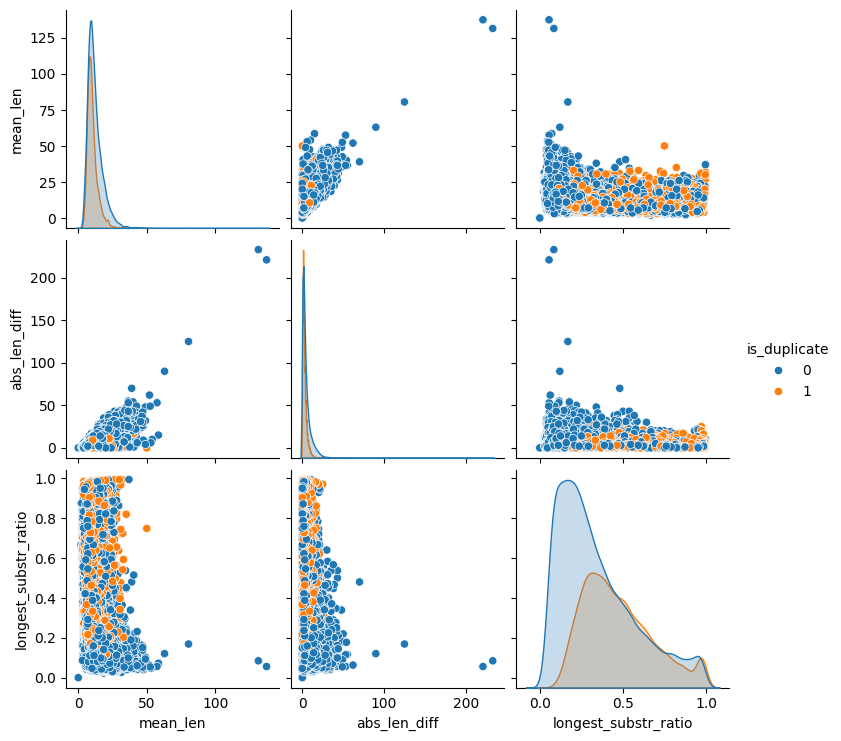

In [32]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

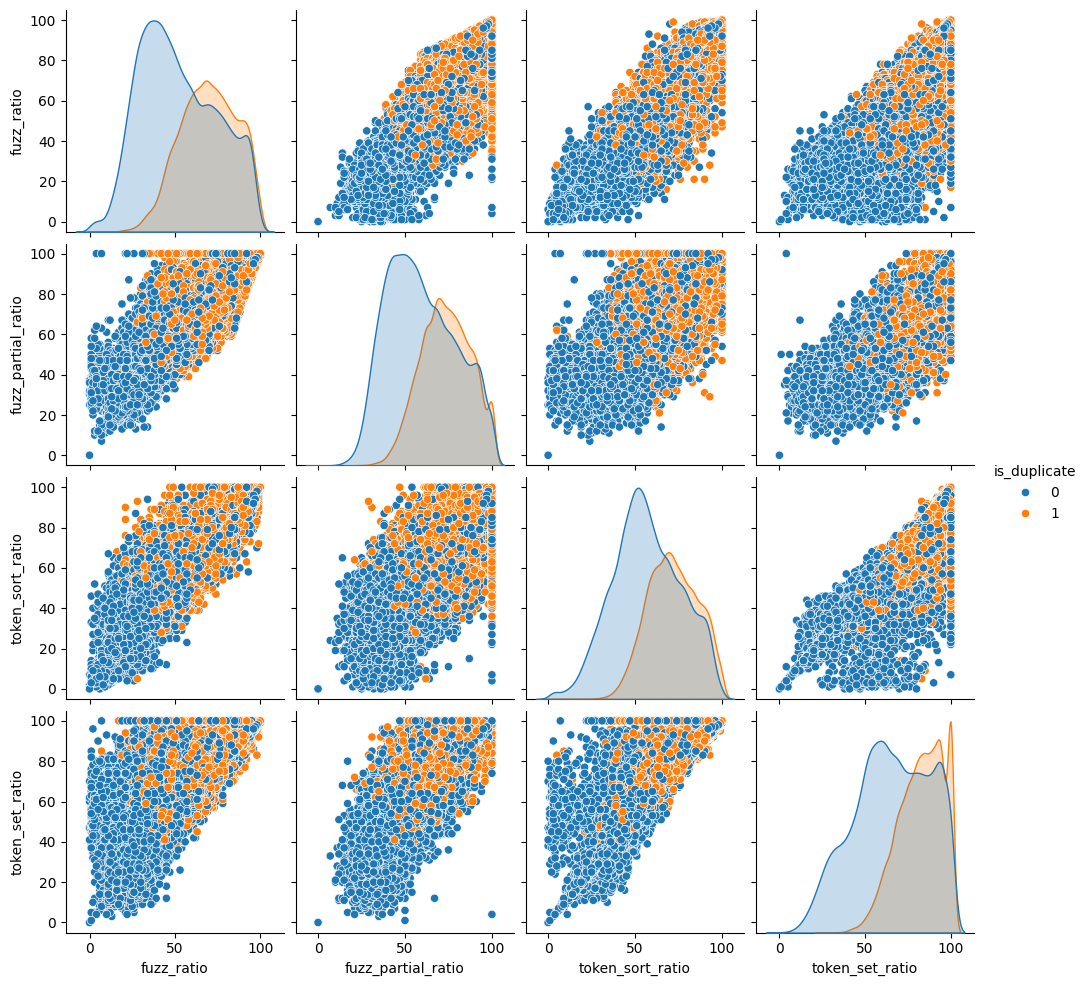

In [33]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [34]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [35]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.018s...
[t-SNE] Computed neighbors for 60000 samples in 6.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

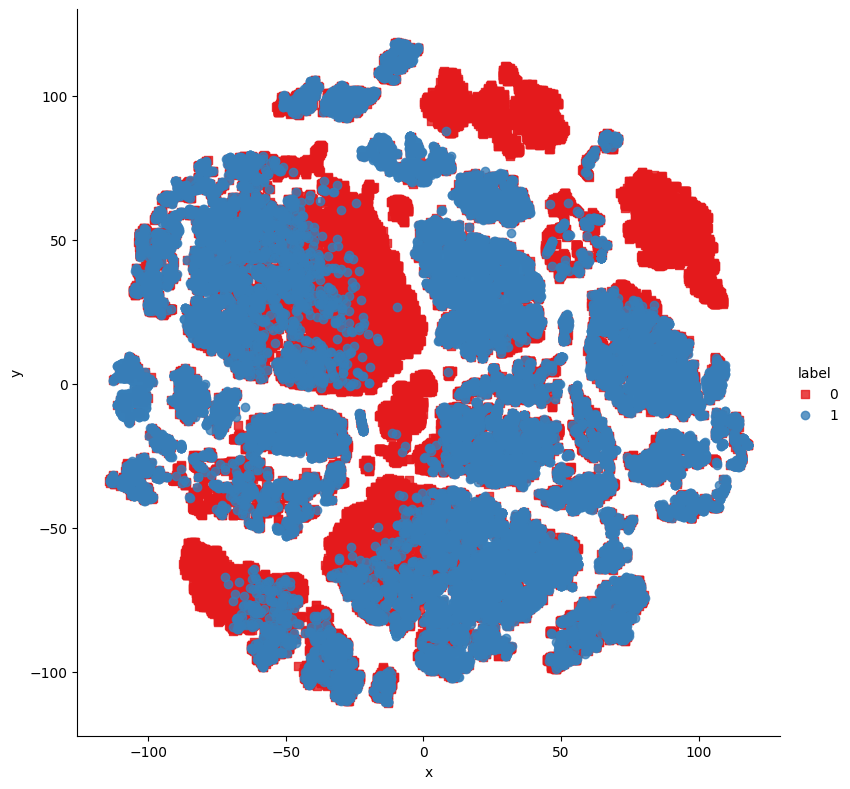

In [36]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, height=8, palette="Set1", markers=['s', 'o'])

In [37]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.018s...
[t-SNE] Computed neighbors for 60000 samples in 6.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

In [38]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')



In [39]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  
398782  what is the best marketing automation tool for...  
115086  i am quite poor and i want to be very rich  wh...  
327711  t i e t to thapar university to thapar univers...  
367788  my boyfriend doesnt feel guilty when he hurts ...  
151235  what was the reason behind the bhopal gas tragedy

In [40]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(60000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        word_total  word_share   cwc_min   cwc_max  ...   ctc_max  \
398782          26        0.46  0.874989  0.874989  ...  0.923070   
115086          24        0.33  0.666644  0.499988  ...  0.466664   
327711          38        0.11  0.000000  0.000000  ...  0.115384   
367788          34        0.03  0.000000  0.000000  ...  0.000000   
151235          13        0.23  0.749981  0.599988  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          26                  29   
367788              0.050847          29                  41   
151235              0.542857          55                  70   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                65               74  
327711                34               43  
367788                23               30  
151235                48               69  

[5 rows x 23 columns]

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=6000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [42]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(60000, 12000)

In [43]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(60000, 12023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        word_total  word_share   cwc_min   cwc_max  ...  5990  5991  5992  \
398782          26        0.46  0.874989  0.874989  ...     0     0     0   
115086          24        0.33  0.666644  0.499988  ...     0     0     0   
327711          38        0.11  0.000000  0.000000  ...     0     0     0   
367788          34        0.03  0.000000  0.000000  ...     0     0     0   
151235          13        0.23  0.749981  0.599988  ...     0     0     0   

        5993  5994  5995  5996  5997  5998  5999  
398782     0     0     0     0     0     0     0  
115086     0     0     0     0     0     0     0  
327711     0     0     0     0     0     0     0  
367788     0     0     0     0     0     0     0  
151235     0     0     0     0     0     0     0  

[5 rows x 12023 columns]

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7991666666666667

In [46]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7983333333333333